In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import sklearn

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. ST data were downloaded from https://www.10xgenomics.com/. The two slices are aligned for visual purposes

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1jDmx8IjiGhOD__spuuhFB1fWVDJtv5CU.

In [5]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure1/data/Mouse_Brain_Merge_Anterior_Posterior_Section_2/filtered_feature_bc_matrix.h5ad")
adata.var_names_make_unique()

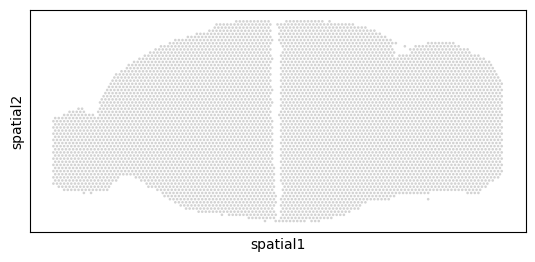

In [6]:
sc.pl.spatial(adata, spot_size = 100)

In [7]:
sc.pp.filter_cells(adata, min_genes=50)
sctm.pp.filter_genes(adata, 0.03,  expression_cutoff_99q = 1)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key = 'data')

In [8]:
sq.gr.spatial_neighbors(adata, library_key = "data")

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):


In [37]:
n_topics = 30
# Only hvgs and fit a total of 30 topics here
# 
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
    categorical_covariate_keys = ['data'],
)

# uses gpu by default   to use cpu use device="cpu"
model.train()

Computing background frequencies


  0%|          | 0/800 [00:00<?, ?it/s]/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.1.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:2210.772:  14%|█▍        | 112/800 [03:05<18:59,  1.66s/it]

Early Stopping


In [38]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata.obs[i] =  topic_prop[i]

In [39]:
top_genes = []
for i in topic_prop.columns:
    top_genes += beta.nlargest(1, i).index.tolist()

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


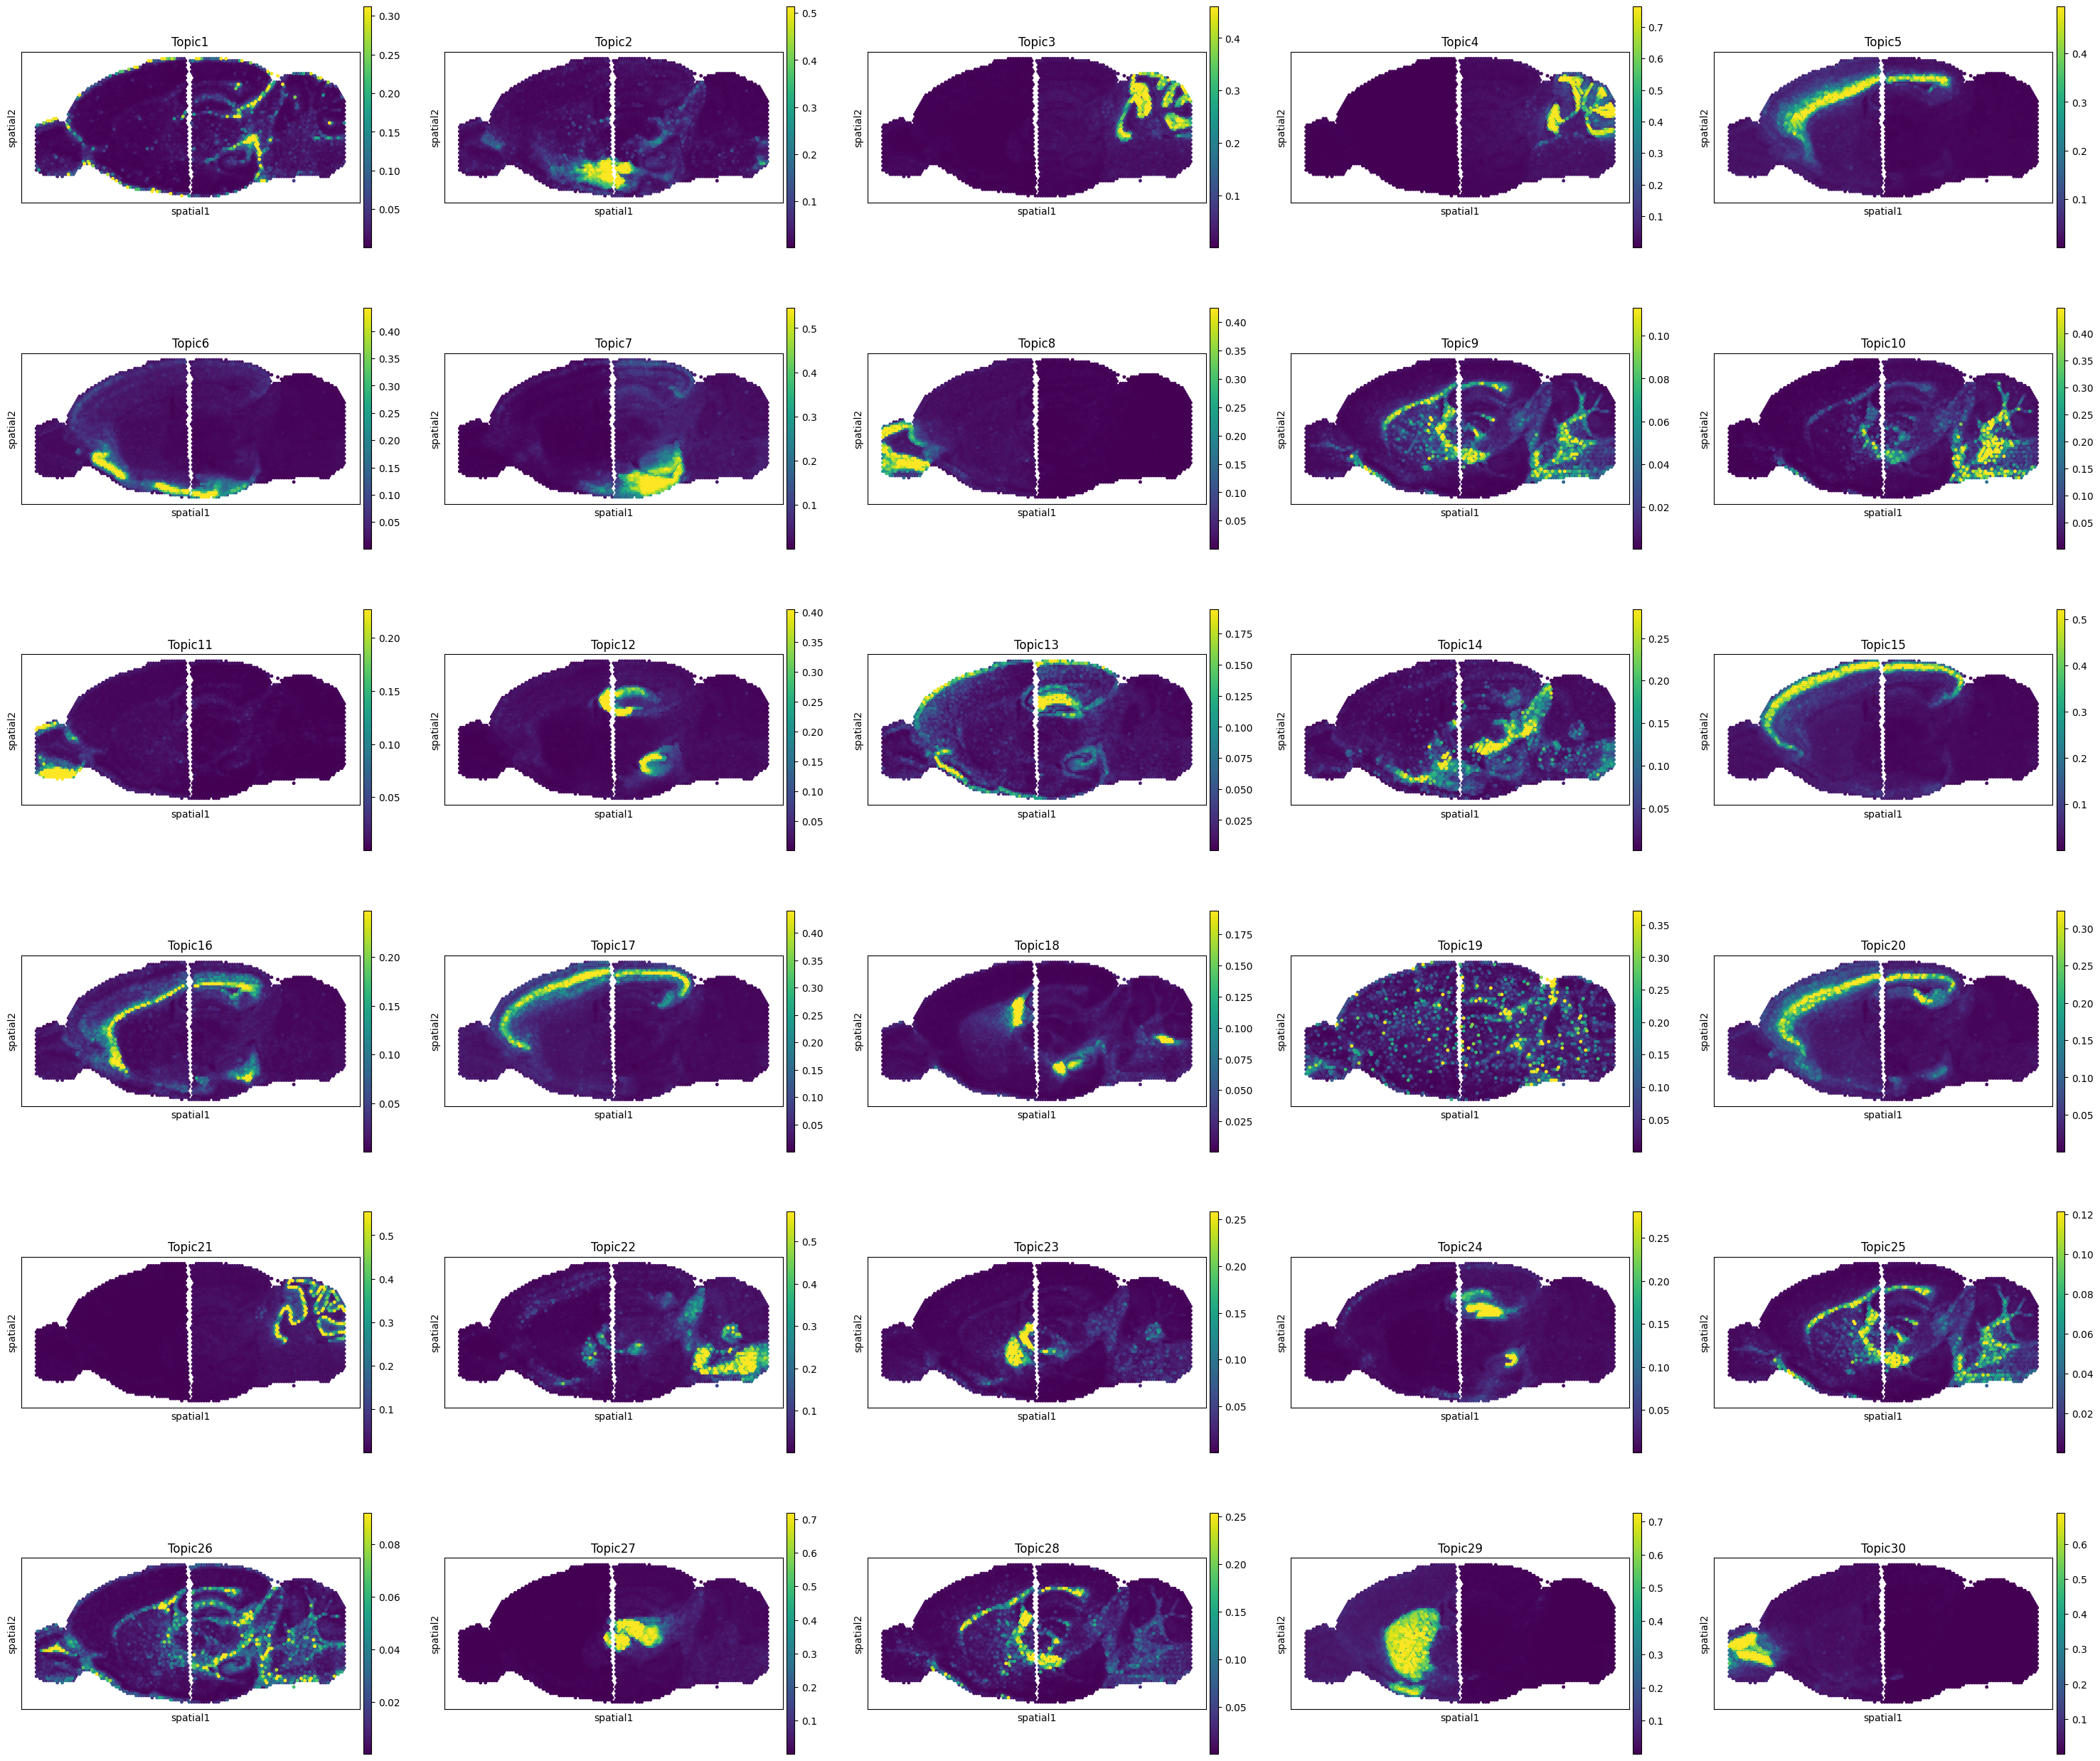

In [40]:
sctm.pl.spatial(adata, color = topic_prop.columns, ncols = 5, size = 50, vmax ='p99')

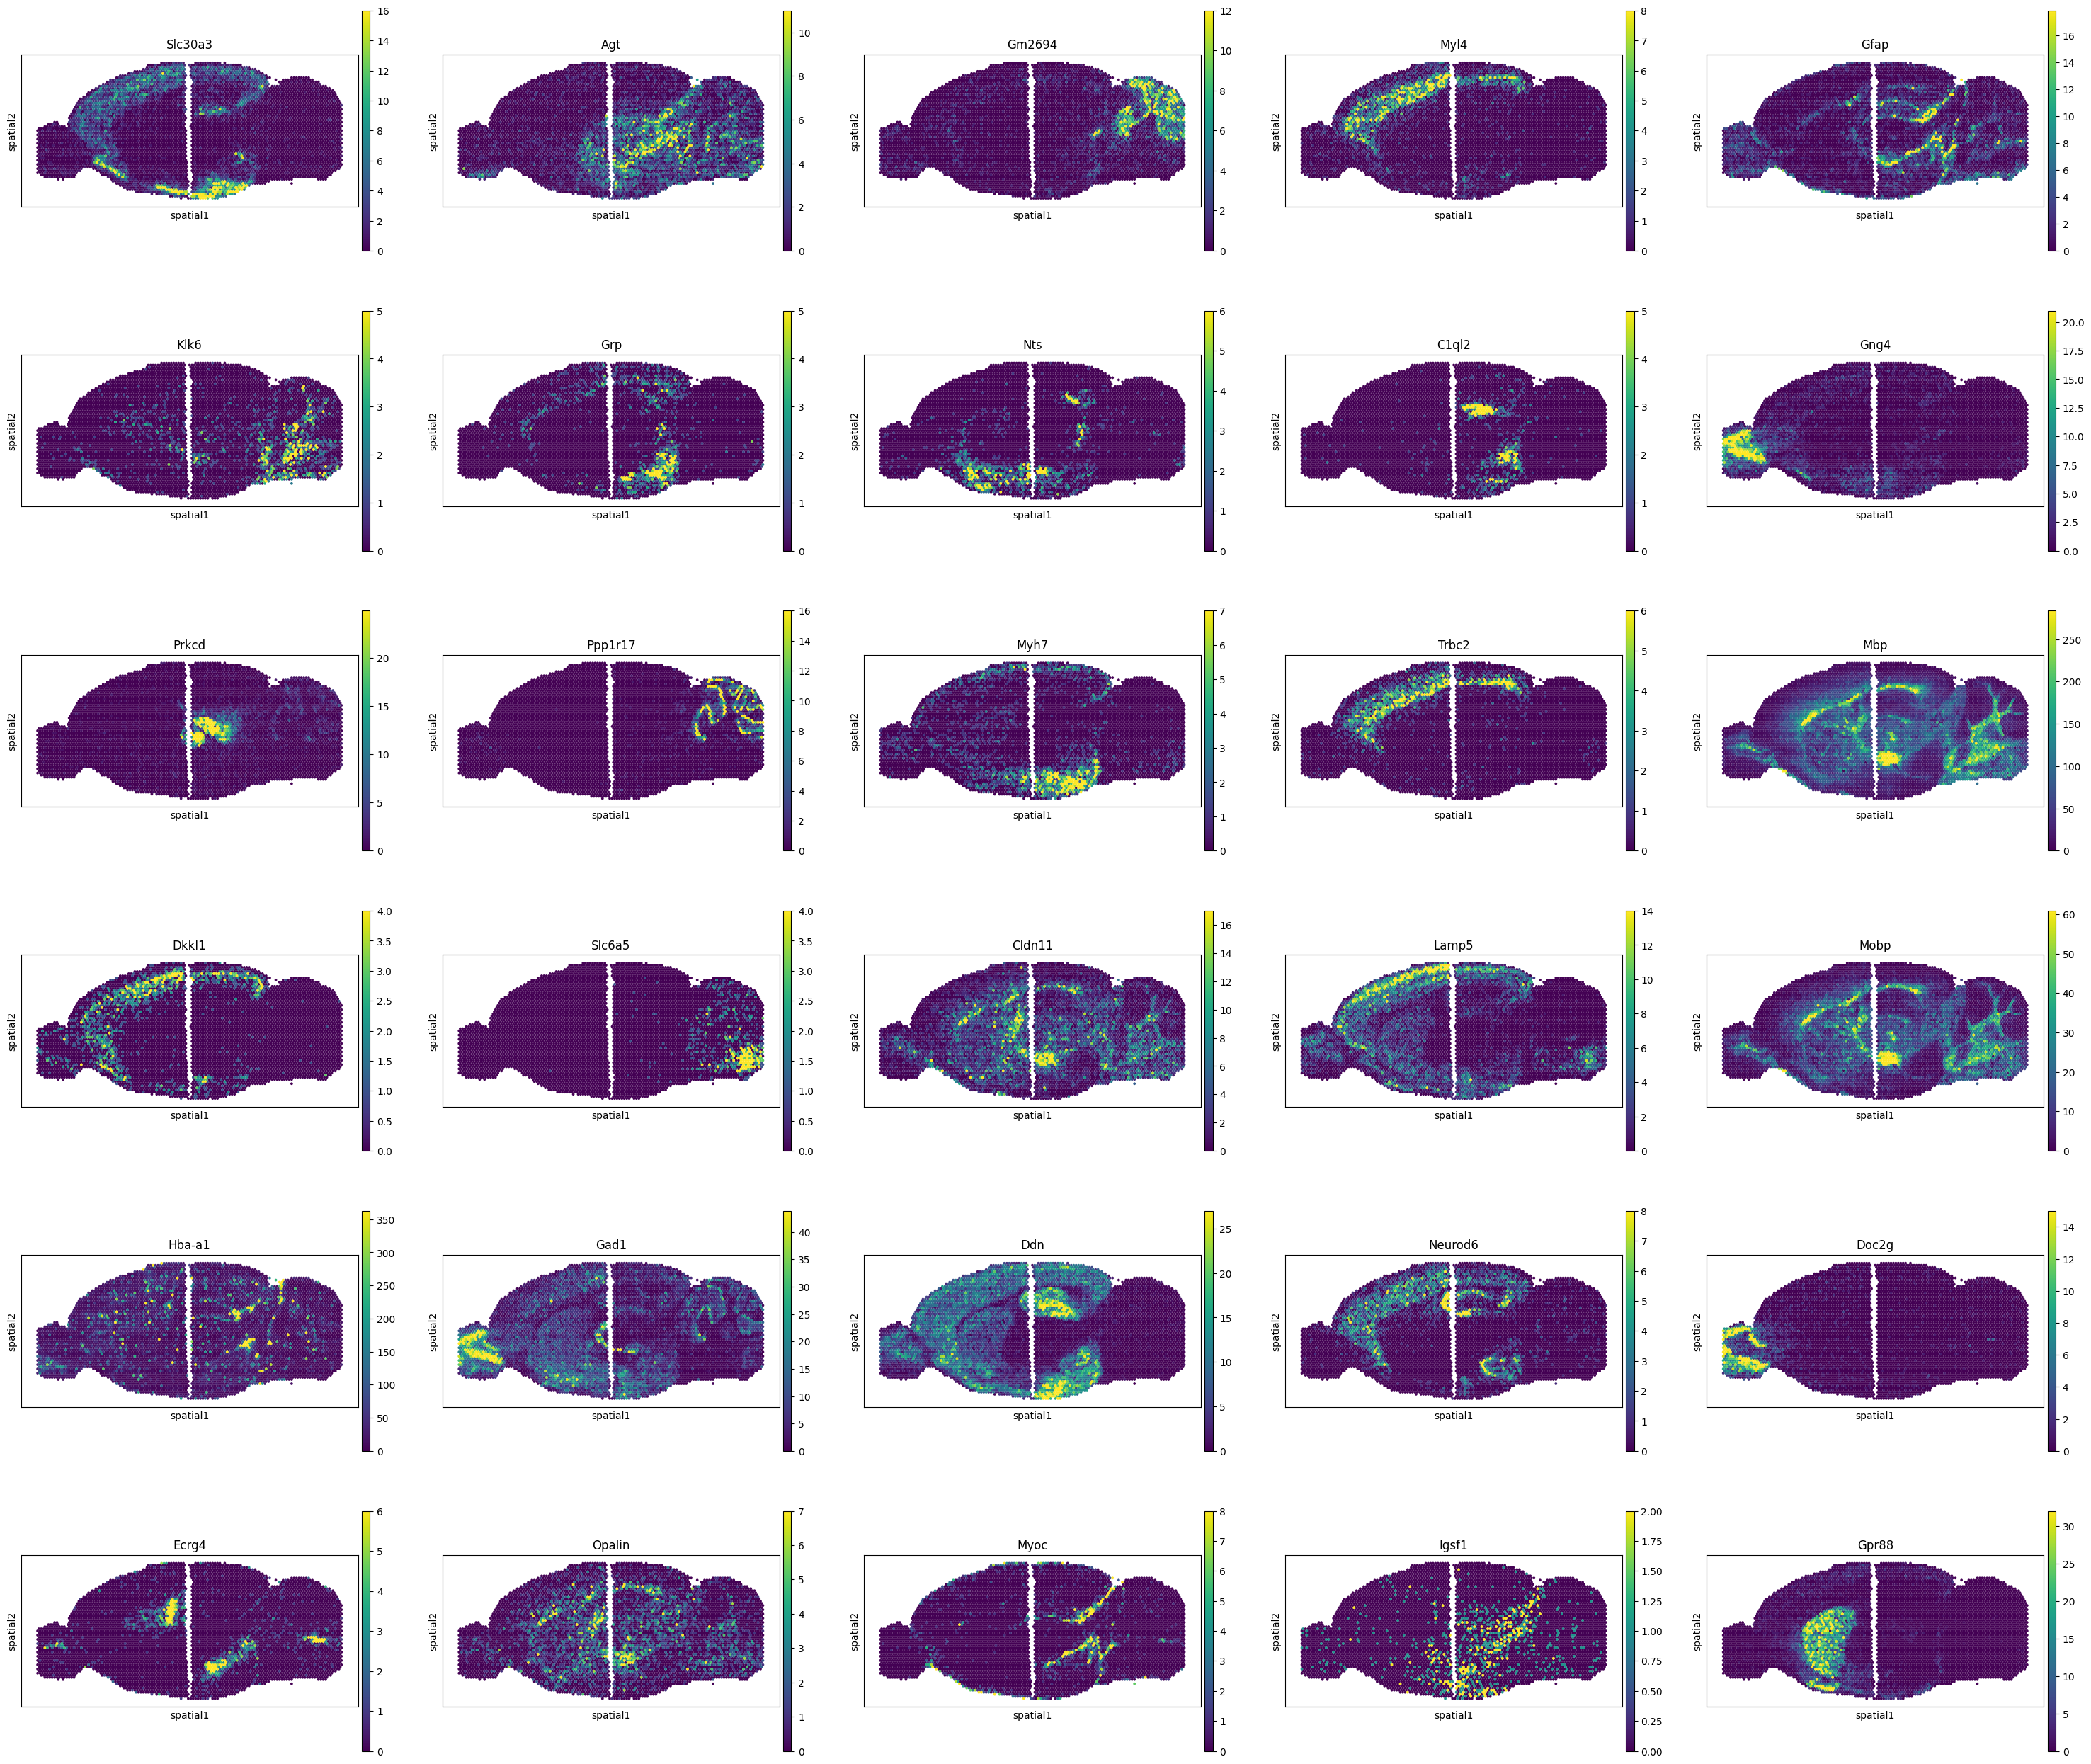

In [14]:
sc.pl.spatial(adata, color = top_genes, ncols = 5, spot_size = 150, vmax ='p99')

Plot out the different layers

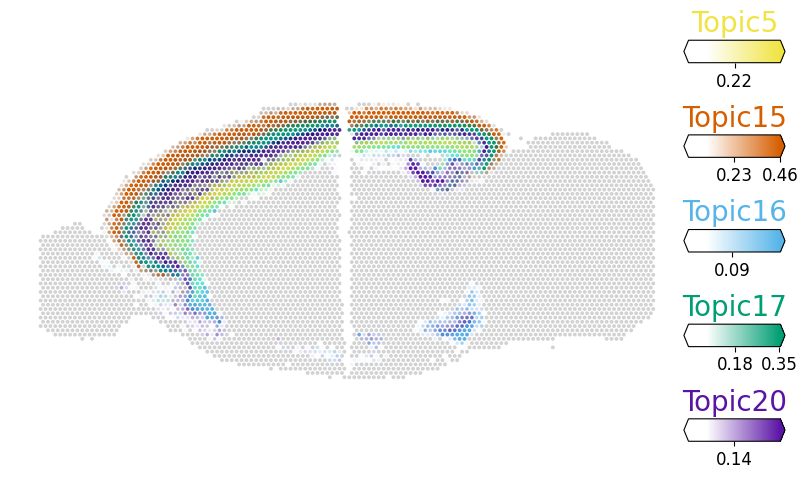

In [41]:
topics = ["Topic5", "Topic15", "Topic16", "Topic17", "Topic20"]
fig = sctm.pl.plot_spatial(adata, topic_prop.loc[:, topics], spot_size = 7,  display_zeros = True, axis_y_flipped = True)